In [1]:
# The following is from "big run"
import sys
sys.path.append('..')
from lib import *
import pandas as pd
import numpy as np

# Setup
lsa_np = np.load('../data/parsed/lsa_output.npy')

metadata = pd.read_pickle('../data/parsed/pickles/pickled_data_test.pickle')
metadata = metadata.loc[metadata['Scenario'] == '401']
metadata = metadata.reset_index(drop=True)

lsa_df = pd.DataFrame(lsa_np)

df = pd.concat([metadata, lsa_df], axis=1, join_axes=[metadata.index])
df = df.loc[df['Label'] != '-1']
df = df.reset_index(drop=True)

cat_features = ['To','From']
features = list(range(100))
features.extend(cat_features + ['Date'])

df = df[features + ['Label'] + ['ID']]


# Built-in incremental learning vs trees training on larger initial sizes

## Initializing control variables

In [2]:
# now using params from sweep

# # temp params 
# n_trees = 32
# tree_depth = 10
# random_seed = 42
# n_max_features = 20
# cat_features = ['To', 'From']

# optimal params
# n_trees = 32
# tree_depth = 90
# random_seed = 42
# n_max_features = 70
# cat_features = ['To', 'From']

n_trees = 32
tree_depth = 70
random_seed = 42
n_max_features = 90
cat_features = ['To', 'From']

## Forests Trained on increasing datasets

In [3]:
forest_100 = RNF(df[:100], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)
forest_200 = RNF(df[:200], n_trees, tree_depth, random_seed, n_max_features, 200, cat_features)
forest_300 = RNF(df[:300], n_trees, tree_depth, random_seed, n_max_features, 300, cat_features)
forest_400 = RNF(df[:400], n_trees, tree_depth, random_seed, n_max_features, 400, cat_features)
forest_500 = RNF(df[:500], n_trees, tree_depth, random_seed, n_max_features, 500, cat_features)
forest_600 = RNF(df[:600], n_trees, tree_depth, random_seed, n_max_features, 600, cat_features)
incremental_forests = [forest_100, forest_200, forest_300, forest_400, forest_500]

In [4]:
for forest in incremental_forests:
    forest.fit_parallel()

In [5]:
# evaluation
for forest in incremental_forests:
    print(evalStats(forest.predict_parallel(df[-100:])[1], df[-100:]), end='\n')

(0.37142857142857144, 0.9285714285714286, 0.77, 0.5306122448979592)

(0.7428571428571429, 0.8125, 0.85, 0.7761194029850748)

(0.7428571428571429, 0.8125, 0.85, 0.7761194029850748)

(0.6285714285714286, 0.7333333333333333, 0.79, 0.6769230769230768)

(0.7142857142857143, 0.78125, 0.83, 0.7462686567164178)



100, 200, ..., 500 document - trained forests
Param

##  Regular Incremental Forests

In [3]:
incremental_forest = RNF(df[0:100], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)

In [4]:
incremental_forest.fit_parallel()
print(evalStats(incremental_forest.predict_parallel(df[-100:])[1], df[-100:]))

(0.5142857142857142, 0.9473684210526315, 0.82, 0.6666666666666666)


In [5]:
incremental_forest.update(df[100:200])
print(evalStats(incremental_forest.predict_parallel(df[-100:])[1], df[-100:]))

incremental_forest.update(df[200:300])
print(evalStats(incremental_forest.predict_parallel(df[-100:])[1], df[-100:]))

incremental_forest.update(df[300:400])
print(evalStats(incremental_forest.predict_parallel(df[-100:])[1], df[-100:]))

incremental_forest.update(df[400:500])
print(evalStats(incremental_forest.predict_parallel(df[-100:])[1], df[-100:]))

18
(0.6, 0.8076923076923077, 0.81, 0.6885245901639345)
before restructuring: there is a 0-row node
before restructuring: there is a 0-row node
before restructuring: there is a 0-row node
before restructuring: there is a 0-row node
10
(0.6857142857142857, 0.8571428571428571, 0.85, 0.7619047619047619)
before restructuring: there is a 0-row node
before restructuring: there is a 0-row node
10
(0.7142857142857143, 0.8064516129032258, 0.84, 0.7575757575757576)
before restructuring: there is a 0-row node
before restructuring: there is a 0-row node
before restructuring: there is a 0-row node
before restructuring: there is a 0-row node
19
(0.6857142857142857, 0.7058823529411765, 0.79, 0.6956521739130436)


In [ ]:
incremental_forest.update(df[500:600])
print(evalStats(incremental_forest.predict_parallel(df[-100:])[1], df[-100:]))

# Testing limited core usage

In [ ]:
f = RNF(df[0:500], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)
f.fit_parallel()

In [ ]:
f.trees[20].visualize()

# Testing 400 incremented vs 400 initial trained

In [ ]:
# incremental forest initially trained on 100 rows
inc_forest = RNF(df[0:100], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)
inc_forest.fit_parallel();

In [ ]:
init_forest = RNF(df[:-100], n_trees, tree_depth, random_seed, n_max_features, 400, cat_features)
init_forest.fit_parallel();

# Comparing Query Strategies

## Query by Committee
Asking for labeling on rows with the most amount of disagreement (between trees)

In [ ]:
committee_rnf = RNF(df[:500], n_trees, tree_depth, random_seed, n_max_features, 500, cat_features)
committee_rnf.fit_parallel()

In [ ]:
predictions = committee_rnf.predict_parallel(df[-100:])

In [22]:
# agreements = predictions[0]
def entropy(pred):
    s = 0
    for x in pred[0]:
        if x != 0:
            s += x * math.log(x)
    return (-1 * s, pred[1])

# entropies = sorted(map(entropy, zip(agreements, predictions[2])), reverse=True)

In [23]:
def committee_increment():
    # initial training
    committee_rnf = RNF(df[:100], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)
    committee_rnf.fit_parallel()
    
    increment_size = 50
    
    test_set = df[-100:]
    train_set = df[:-100]
    
    labeled_ids = df.loc[:100, 'ID'].values
    #trying to use -100: with df.loc just returns everything, so we need to get a little tricky
    test_ids = df.iloc[-100:, df.columns.get_loc('ID')].values
    labeled_ids = np.append(labeled_ids, test_ids)
    test_results = committee_rnf.predict_parallel(df.loc[df['ID'].isin(test_ids)])
    print(evalStats(test_results[1], df.loc[df['ID'].isin(test_ids)]))
    for i in range(((df.shape[0] - 100) // increment_size) - 1):
        # initial train scores
        unlabeled_predict = committee_rnf.predict_parallel(df.loc[np.logical_not(df['ID'].isin(labeled_ids))])

        to_label = sorted(map(entropy, zip(unlabeled_predict[0], unlabeled_predict[2])), reverse=True)[:increment_size]

        to_label_ids = [x[1] for x in to_label]

        labeled_ids = np.append(labeled_ids, to_label_ids)

        increment_df = df.loc[df["ID"].isin(to_label_ids)]
        
        committee_rnf.update(increment_df)
    
        test_results = committee_rnf.predict_parallel(df.loc[df['ID'].isin(test_ids)])
        print(evalStats(test_results[1], df.loc[df['ID'].isin(test_ids)]))
        
committee_increment()

(0.5142857142857142, 0.9473684210526315, 0.82, 0.6666666666666666)
18
(0.5142857142857142, 0.72, 0.76, 0.6)
9
(0.7142857142857143, 0.6578947368421053, 0.77, 0.684931506849315)
25
(0.7428571428571429, 0.6190476190476191, 0.75, 0.6753246753246753)
19
when splitting categorically, no best address found: [240 133 240 240 240]
when splitting categorically, no best address found: [240 133 240 240 240]
when splitting categorically, no best address found: [240 133 240 240 240]
when splitting categorically, no best address found: [240 133 240 240 240]
when splitting categorically, no best address found: [240 133 240 240 240]
when splitting categorically, no best address found: [240 133 240 240 240]
when splitting categorically, no best address found: [240 133 240 240 240]
when splitting categorically, no best address found: [240 133 240 240 240]
when splitting categorically, no best address found: [240 133 240 240 240]
when splitting categorically, no best address found: [240 133 240 240 240]
(

In [ ]:
def committee_increment_copy():
    # initial training
    committee_rnf = RNF(df[:100], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)
    committee_rnf.fit_parallel()
    
    increment_size = 50
    
    test_set = df[-100:]
    train_set = df[:-100]
    
    print('Initial performance')
    print(evalStats(committee_rnf.predict_parallel(test_set)[1], test_set))
    
    for i in range(5):
        to_predict_on = train_set[~train_set['ID'].isin(committee_rnf.train_data['ID'])].dropna()
        print('the effective size of the train_set is {}'.format(to_predict_on.shape[0]))
        predictions = committee_rnf.predict_parallel(to_predict_on)
        
        least_agreement = sorted(zip(predictions[0], predictions[2]), key= lambda x: entropy(x), reverse=True)[:100]
        least_agreement_ids = [x[1] for x in least_agreement]
#         print(most_confident_ids)
        incrementing_set = train_set[train_set['ID'].isin(least_agreement_ids)]
        committee_rnf.update(incrementing_set)
        print(evalStats(committee_rnf.predict_parallel(test_set)[1], test_set))
        
committee_increment_copy()

Initial performance
(0.37142857142857144, 0.9285714285714286, 0.77, 0.5306122448979592)
the effective size of the train_set is 510
17
(0.5428571428571428, 0.95, 0.83, 0.6909090909090908)
the effective size of the train_set is 410
20
(0.7142857142857143, 0.6410256410256411, 0.76, 0.6756756756756757)
the effective size of the train_set is 310
18


# Plotting some results from 32/10/20 
Comparing basic incremental learning trained on 100, 200, 300, 400, and 500 documents to the query-by-committee strategy

In [1]:
inc = [(0.2857142857142857, 1.0, 0.75, 0.4444444444444445),
(0.4, 0.9333333333333333, 0.78, 0.5599999999999999),
(0.4, 0.9333333333333333, 0.78, 0.5599999999999999),
(0.7714285714285715, 0.8181818181818182, 0.86, 0.7941176470588236),
(0.8857142857142857, 0.5081967213114754, 0.66, 0.6458333333333334)]
comm_quer = [(0.2857142857142857, 1.0, 0.75, 0.4444444444444445),
(0.5142857142857142, 0.9473684210526315, 0.82, 0.6666666666666666),
(0.8571428571428571, 0.7317073170731707, 0.84, 0.7894736842105263),
(0.9142857142857143, 0.5517241379310345, 0.71, 0.6881720430107526),
(0.9428571428571428, 0.559322033898305, 0.72, 0.7021276595744681)]
hom_quer = [(0.2857142857142857, 1.0, 0.75, 0.4444444444444445),
            (0.6857142857142857, 0.75, 0.81, 0.7164179104477612),
            (0.7142857142857143, 0.5952380952380952, 0.73, 0.6493506493506493),
            (0.37142857142857144, 0.6190476190476191, 0.7, 0.4642857142857143),
            (0.9142857142857143, 0.4266666666666667, 0.54, 0.5818181818181819)]

In [2]:
%matplotlib inline
import matplotlib


# matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [3]:
inc_prec = [x[0] for x in inc]
inc_rec = [x[1] for x in inc]
inc_acc = [x[2] for x in inc]
inc_f1 = [x[3] for x in inc]
comm_prec = [x[0] for x in comm_quer]
comm_rec = [x[1] for x in comm_quer]
comm_acc = [x[2] for x in comm_quer]
comm_f1 = [x[3] for x in comm_quer]
hom_prec = [x[0] for x in hom_quer]
hom_rec = [x[1] for x in hom_quer]
hom_acc = [x[2] for x in hom_quer]
hom_f1 = [x[3] for x in hom_quer]


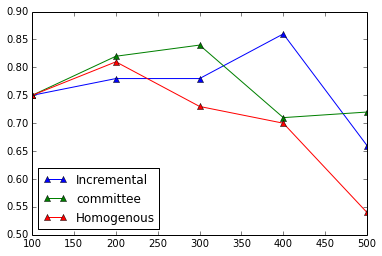

In [4]:
#plot some data
x = range(100,600,100)

fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(x, inc_acc, marker="^", label="Incremental")
ax.plot(x, comm_acc, marker="^", label="committee")
ax.plot(x, hom_acc, marker = "^", label="Homogenous")

plt.legend(loc=3)
plt.draw()
plt.show()

In [24]:
def homogenous_increment():
    '''Incremental training, but tries to give data points that even out the proportions of relevant vs not relevant
        rows that the forest has'''
    homogenous_rnf = RNF(df[:100], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)
    homogenous_rnf.fit_parallel()
    
    labeled_ids = df.loc[:100, 'ID'].values
    #trying to use -100: with df.loc just returns everything, so we need to get a little tricky
    test_ids = df.iloc[-100:, df.columns.get_loc('ID')].values
    labeled_ids = np.append(labeled_ids, test_ids)
    test_results = homogenous_rnf.predict_parallel(df.loc[df['ID'].isin(test_ids)])
    print(evalStats(test_results[1], df.loc[df['ID'].isin(test_ids)]))
    
    # incremental steps
    for i in range(5):
        # add 100 rows at each increment
        num_new_rows = 100
            
        # get ratio in the forest's training data
        num_relevant = homogenous_rnf.train_data[homogenous_rnf.train_data['Label']=='1'].shape[0]
        num_irrelevant = homogenous_rnf.train_data[homogenous_rnf.train_data['Label']=='0'].shape[0]
        print('forest has {} relevant and {} irrelevant docs in the training set'.format(num_relevant, num_irrelevant))
    
        # look at the distribution of new data points
        if (num_irrelevant > num_relevant):
            print('here1')
            # need to supplement relevant docs
            difference = num_irrelevant - num_relevant
            num_new_rel = difference + (num_new_rows - difference) // 2
            num_new_irr = num_new_rows - num_new_rel
        elif (num_relevant > num_irrelevant):
            print('here2')
            difference = num_relevant - num_irrelevant
            num_new_irr = difference + (num_new_rows - difference) // 2
            num_new_rel = num_new_rows - num_new_irr
        else:
            print('here3')
            num_new_irr = num_new_rows // 2
            num_new_rel = num_new_rows - num_new_irr
        print('rel rows added: {}, irr rows added: {}'.format(num_new_rel, num_new_irr))
        
        # predict on all of the rest of the training set that hasn't been added to the forest
#         unlabeled_predict = committee_rnf.predict_parallel(df.loc[np.logical_not(df['ID'].isin(labeled_ids))])
        not_yet_labeled = df.loc[np.logical_not(df['ID'].isin(labeled_ids))]
        not_yet_labeled_rel = not_yet_labeled[not_yet_labeled['Label'] == '1']
        not_yet_labeled_irr = not_yet_labeled[not_yet_labeled['Label'] == '0']
        
        if not not_yet_labeled_rel.shape[0] >= num_new_rel:
            continue
        elif not not_yet_labeled_irr.shape[0] >= num_new_irr:
            continue
        else:
#             to_add = .append(not_yet_labeled_rel, not_yet_labeled_irr)
            rel_to_add = not_yet_labeled_rel[:num_new_rel]
            irr_to_add = not_yet_labeled_irr[:num_new_irr]
            to_add = rel_to_add.append(irr_to_add)
            to_add_ids = to_add['ID'].values
            
            homogenous_rnf.update(to_add)
            test_results = homogenous_rnf.predict_parallel(df.loc[df['ID'].isin(test_ids)])
            print(evalStats(test_results[1], df.loc[df['ID'].isin(test_ids)]))
            labeled_ids = np.append(labeled_ids, to_add_ids)
            

#         to_label = sorted(map(entropy, zip(unlabeled_predict[0], unlabeled_predict[2])), reverse=True)[:100]

#         to_label_ids = [x[1] for x in to_label]

#         labeled_ids = np.append(labeled_ids, to_label_ids)

#         increment_df = df.loc[df["ID"].isin(to_label_ids)]
        
#         committee_rnf.update(increment_df)
    
#         test_results = committee_rnf.predict_parallel(df.loc[df['ID'].isin(test_ids)])
#         print(evalStats(test_results[1], df.loc[df['ID'].isin(test_ids)]))
        
        
homogenous_increment()
        
    

(0.5142857142857142, 0.9473684210526315, 0.82, 0.6666666666666666)
forest has 17 relevant and 83 irrelevant docs in the training set
here1
rel rows added: 83, irr rows added: 17
18
(0.8571428571428571, 0.7692307692307693, 0.86, 0.8108108108108107)
forest has 100 relevant and 100 irrelevant docs in the training set
here3
rel rows added: 50, irr rows added: 50
12
(0.8571428571428571, 0.6976744186046512, 0.82, 0.7692307692307693)
forest has 150 relevant and 150 irrelevant docs in the training set
here3
rel rows added: 50, irr rows added: 50
before restructuring: there is a 0-row node
before restructuring: there is a 0-row node
14
(0.6857142857142857, 0.7058823529411765, 0.79, 0.6956521739130436)
forest has 200 relevant and 200 irrelevant docs in the training set
here3
rel rows added: 50, irr rows added: 50
24
(0.5714285714285714, 0.7142857142857143, 0.77, 0.634920634920635)
forest has 250 relevant and 250 irrelevant docs in the training set
here3
rel rows added: 50, irr rows added: 50


# Plotting results from 32/90/70

In [14]:
inc = [(0.37142857142857144, 0.9285714285714286, 0.77, 0.5306122448979592),
       (0.6571428571428571, 0.7666666666666667, 0.81, 0.7076923076923077),
       (0.7428571428571429, 0.7647058823529411, 0.83, 0.7536231884057971),
       (0.6857142857142857, 0.7272727272727273, 0.8, 0.7058823529411764),
       (0.8, 0.7, 0.81, 0.7466666666666666),
       (0.8, 0.6829268292682927, 0.8, 0.736842105263158)]
comm_quer = [(0.37142857142857144, 0.9285714285714286, 0.77, 0.5306122448979592),
             (0.5428571428571428, 0.95, 0.83, 0.6909090909090908),
             (0.7142857142857143, 0.6410256410256411, 0.76, 0.6756756756756757),
             (0.6857142857142857, 0.631578947368421, 0.75, 0.6575342465753424),
             (0.7142857142857143, 0.5813953488372093, 0.72, 0.6410256410256411),
             (0.45714285714285713, 0.6153846153846154, 0.71, 0.5245901639344263)]
hom_quer = [(0.37142857142857144, 0.9285714285714286, 0.77, 0.5306122448979592),
            (0.6571428571428571, 0.6764705882352942, 0.77, 0.6666666666666666),
            (0.7714285714285715, 0.6585365853658537, 0.78, 0.7105263157894737),
            (0.6, 0.8076923076923077, 0.81, 0.6885245901639345),
            (0.5714285714285714, 0.7142857142857143, 0.77, 0.634920634920635),
            (0.5714285714285714, 0.7142857142857143, 0.77, 0.634920634920635)]
mc_quer = [(0.37142857142857144, 0.9285714285714286, 0.77, 0.5306122448979592),
           (0.4, 0.6666666666666666, 0.72, 0.5),
           (0.5142857142857142, 0.72, 0.76, 0.6),
           (0.6285714285714286, 0.6111111111111112, 0.73, 0.619718309859155),
           (0.7428571428571429, 0.7222222222222222, 0.81, 0.732394366197183),
           (0.8285714285714286, 0.6590909090909091, 0.79, 0.7341772151898734)]
non_inc_quer = [(0.37142857142857144, 0.9285714285714286, 0.77, 0.5306122448979592),
                (0.7428571428571429, 0.8125, 0.85, 0.7761194029850748),
                (0.7428571428571429, 0.8125, 0.85, 0.7761194029850748),
                (0.6285714285714286, 0.7333333333333333, 0.79, 0.6769230769230768),
                (0.7142857142857143, 0.78125, 0.83, 0.7462686567164178),
               (0.7142857142857143, 0.78125, 0.83, 0.7462686567164178)]

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [15]:
inc_prec = [x[0] for x in inc]
inc_rec = [x[1] for x in inc]
inc_acc = [x[2] for x in inc]
inc_f1 = [x[3] for x in inc]
comm_prec = [x[0] for x in comm_quer]
comm_rec = [x[1] for x in comm_quer]
comm_acc = [x[2] for x in comm_quer]
comm_f1 = [x[3] for x in comm_quer]
hom_prec = [x[0] for x in hom_quer]
hom_rec = [x[1] for x in hom_quer]
hom_acc = [x[2] for x in hom_quer]
hom_f1 = [x[3] for x in hom_quer]
mc_prec = [x[0] for x in mc_quer]
mc_rec = [x[1] for x in mc_quer]
mc_acc = [x[2] for x in mc_quer]
mc_f1 = [x[3] for x in mc_quer]
non_inc_prec = [x[0] for x in non_inc_quer]
non_inc_rec = [x[1] for x in non_inc_quer]
non_inc_acc = [x[2] for x in non_inc_quer]
non_inc_f1 = [x[3] for x in non_inc_quer]

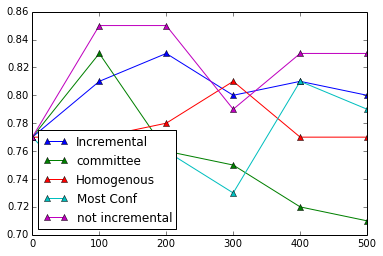

In [19]:
#plot some data
x = range(0,600,100)

fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(x, inc_acc, marker="^", label="Incremental")
ax.plot(x, comm_acc, marker="^", label="committee")
ax.plot(x, hom_acc, marker = "^", label="Homogenous")
ax.plot(x, mc_acc, marker = "^", label="Most Conf")
ax.plot(x, non_inc_acc, marker = "^", label="not incremental")

plt.legend(loc=3)
plt.draw()
plt.show()

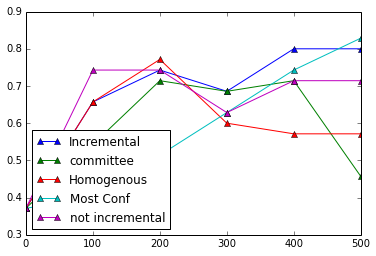

In [18]:
#plot some data
x = range(0,600,100)

fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(x, inc_prec, marker="^", label="Incremental")
ax.plot(x, comm_prec, marker="^", label="committee")
ax.plot(x, hom_prec, marker = "^", label="Homogenous")
ax.plot(x, mc_prec, marker = "^", label="Most Conf")
ax.plot(x, non_inc_prec, marker = "^", label="not incremental")

plt.legend(loc=3)
plt.draw()
plt.show()

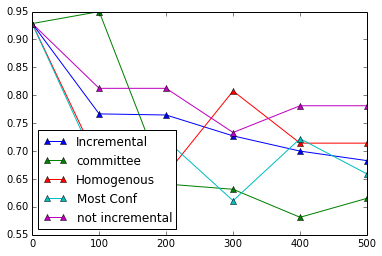

In [17]:
#plot some data
x = range(0,600,100)

fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(x, inc_rec, marker="^", label="Incremental")
ax.plot(x, comm_rec, marker="^", label="committee")
ax.plot(x, hom_rec, marker = "^", label="Homogenous")
ax.plot(x, mc_rec, marker = "^", label="Most Conf")
ax.plot(x, non_inc_rec, marker = "^", label="not incremental")

plt.legend(loc=3)
plt.draw()
plt.show()

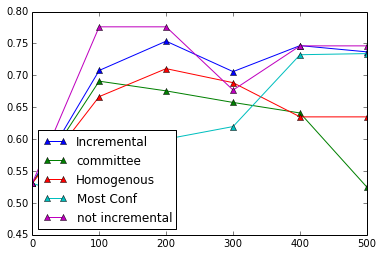

In [16]:
#plot some data
x = range(0,600,100)

fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(x, inc_f1, marker="^", label="Incremental")
ax.plot(x, comm_f1, marker="^", label="committee")
ax.plot(x, hom_f1, marker = "^", label="Homogenous")
ax.plot(x, mc_f1, marker = "^", label="Most Conf")
ax.plot(x, non_inc_f1,marker = "^", label="not incremental")

plt.legend(loc=3)
plt.draw()
plt.show()

# Incrementing with the most confident data

In [30]:
def most_confident_increment():
    '''
    Increments by 100 each run. Takes the 100 most confident data points to use add to the training set
    '''
    mc_rnf = RNF(df[:100], n_trees, tree_depth, random_seed, n_max_features, 100, cat_features)
    mc_rnf.fit_parallel()
    
    test_set = df[-100:]
    train_set = df[:-100]
    
    print('Initial performance')
    print(evalStats(mc_rnf.predict_parallel(test_set)[1], test_set))
    
    for i in range(5):
        to_predict_on = train_set[~train_set['ID'].isin(mc_rnf.train_data['ID'])].dropna()
        print('the effective size of the train_set is {}'.format(to_predict_on.shape[0]))
        predictions = mc_rnf.predict_parallel(to_predict_on)
        
        most_confident = sorted(zip(predictions[0], predictions[2]), key= lambda x: abs(x[0][1] - x[0][0]), reverse=True)[:100]
        most_confident_ids = [x[1] for x in most_confident]
#         print(most_confident_ids)
        incrementing_set = train_set[train_set['ID'].isin(most_confident_ids)]
        mc_rnf.update(incrementing_set)
        print(evalStats(mc_rnf.predict_parallel(test_set)[1], test_set))
    
most_confident_increment()
        

Initial performance
(0.37142857142857144, 0.9285714285714286, 0.77, 0.5306122448979592)
the effective size of the train_set is 510
17
(0.4, 0.6666666666666666, 0.72, 0.5)
the effective size of the train_set is 410
17
(0.5142857142857142, 0.72, 0.76, 0.6)
the effective size of the train_set is 310
18
(0.6285714285714286, 0.6111111111111112, 0.73, 0.619718309859155)
the effective size of the train_set is 210
19
(0.7428571428571429, 0.7222222222222222, 0.81, 0.732394366197183)
the effective size of the train_set is 110
19
(0.8285714285714286, 0.6590909090909091, 0.79, 0.7341772151898734)
